In [1]:
# load pandas and numpy
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns

def get_tables(is_covariates, models, datasets, time_steps):
    # create dataframes for MSE and MAE with columns for each dataset and rows for each model
    df_rmse = pd.DataFrame(columns=[dataset + ' ID' for dataset in datasets] + 
                        [dataset + ' OD' for dataset in datasets], index=models)
    df_mae = pd.DataFrame(columns=[dataset + ' ID' for dataset in datasets] +
                            [dataset + ' OD' for dataset in datasets], index=models)
    df_likelihood = pd.DataFrame(columns=[dataset + ' ID' for dataset in datasets] +
                            [dataset + ' OD' for dataset in datasets], index=models[1:]) # no likelihood for ARIMA
    df_calibration = pd.DataFrame(columns=[dataset + ' ID' for dataset in datasets] +
                            [dataset + ' OD' for dataset in datasets], index=models[1:]) # no calibration for ARIMA
    error_bars = pd.DataFrame(columns=["dataset", "model", "type", "error_type", "error_value"])

    for model in models:
        for dataset in datasets:
            filename = f"../output/{model}_{dataset}.txt" if not is_covariates else f"../output/{model}_covariates_{dataset}.txt"

            if not os.path.isfile(filename):
                print(filename)
                continue

            with open(filename, 'r') as f:
                for line in f:
                    if line.startswith('ID median of (MSE, MAE):'):
                        id_mse_mae = re.findall(r'\d+\.\d+', line)
                        df_rmse.loc[model, dataset + ' ID'] = float(id_mse_mae[0])**0.5
                        df_mae.loc[model, dataset + ' ID'] = float(id_mse_mae[1])

                        if len(id_mse_mae) > 2:
                            error_bars.loc[len(error_bars)] = [dataset, model, "ID", "RMSE", float(id_mse_mae[2])**0.5]

                    elif line.startswith('OOD median of (MSE, MAE):'):
                        od_mse_mae = re.findall(r'\d+\.\d+', line)
                        df_rmse.loc[model, dataset + ' OD'] = float(od_mse_mae[0])**0.5
                        df_mae.loc[model, dataset + ' OD'] = float(od_mse_mae[1])
                        
                        if len(od_mse_mae) > 2:
                            error_bars.loc[len(error_bars)] = [dataset, model, "OD", "RMSE", float(od_mse_mae[2])**0.5]
                        
                    elif line.startswith('ID likelihoods:'):
                        id_likelihoods = re.findall(r'-?\d+\.\d+', line)
                        df_likelihood.loc[model, dataset + ' ID'] = float(id_likelihoods[0])

                    elif line.startswith('OOD likelihoods:'):
                        ood_likelihoods = re.findall(r'-?\d+\.\d+', line)
                        df_likelihood.loc[model, dataset + ' OOD'] = float(ood_likelihoods[0])

                    elif line.startswith('ID calibration errors:'):
                        id_calib = re.findall(r'-?\d+\.\d+', line)
                        id_calib = np.mean([float(x) for x in id_calib[:time_steps]])
                        df_calibration.loc[model, dataset + ' ID'] = id_calib

                    elif line.startswith('OOD calibration errors:'):
                        ood_calib = re.findall(r'-?\d+\.\d+', line)
                        ood_calib = np.mean([float(x) for x in ood_calib[:time_steps]])
                        df_calibration.loc[model, dataset + ' OD'] = ood_calib
    
    # sort columns for all dataframes
    df_rmse = df_rmse.reindex(sorted(df_rmse.columns), axis=1)
    df_mae = df_mae.reindex(sorted(df_mae.columns), axis=1)
    df_likelihood = df_likelihood.reindex(sorted(df_likelihood.columns), axis=1)
    df_calibration = df_calibration.reindex(sorted(df_calibration.columns), axis=1)

    return df_rmse, df_mae, df_likelihood, df_calibration, error_bars

models = ['arima', 'nhits', 'tft', 'linreg', 'xgboost', 'transformer']
datasets = ['weinstock', 'dubosson', 'colas', 'iglu', 'hall']
time_steps = 12

df_nocov_rmse, df_nocov_mae, _, _, error_bars_nocov = get_tables(False, models, datasets, time_steps) 

nocovmodels = [m for m in models if m != "arima"]
df_cov_rmse, df_cov_mae, _, _, error_bars_cov = get_tables(True, models, datasets, time_steps) 

../output/arima_covariates_weinstock.txt
../output/arima_covariates_dubosson.txt
../output/arima_covariates_colas.txt
../output/arima_covariates_iglu.txt
../output/arima_covariates_hall.txt


In [2]:
def rename_data(df):
    df = df.replace({
        'arima': 'AR.',
        'nhits': 'NHiTS',
        'tft': 'TFT',
        'linreg': 'Regres.',
        'xgboost': 'XGBoost',
        'transformer': 'Transf.',
        'colas': 'Colas',
        'dubosson': 'Dubosson',
        'hall': 'Hall',
        'iglu': 'Broll',
        'weinstock': 'Weinstock',
    }, regex=True)
    
    return df

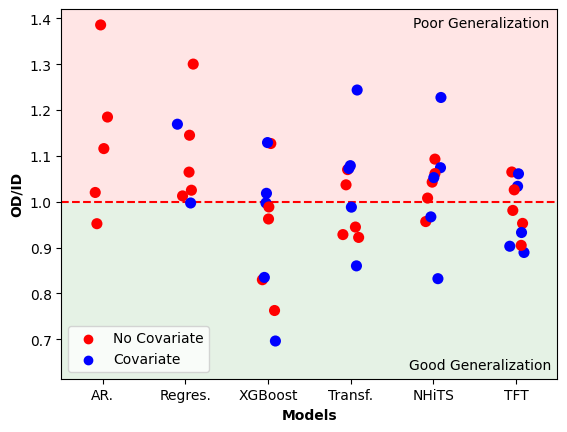

In [3]:
import matplotlib.pyplot as plt
plt.figure()

# 2. ID compared to OOD - axis along datasets
ratios = pd.DataFrame()

for model in models:
    od_div_id = []

    for dataset in datasets:
        delta_nocov = df_nocov_rmse.filter(items=[model], axis=0)[f"{dataset} OD"]/df_nocov_rmse.filter(items=[model], axis=0)[f"{dataset} ID"]
        delta_cov = df_cov_rmse.filter(items=[model], axis=0)[f"{dataset} OD"]/df_cov_rmse.filter(items=[model], axis=0)[f"{dataset} ID"]

        # print(delta_nocov.index)

        od_div_id.append((delta_nocov.index.values[0], delta_nocov[0], "No Covariate"))
        od_div_id.append((delta_cov.index.values[0], delta_cov[0], "Covariate"))

    ratios = pd.concat([ratios, pd.DataFrame(od_div_id)])

df = ratios.dropna()
df = df[df[1] < 10]
df = rename_data(df)
df

fig = sns.stripplot(
    df,
    x=df[0],
    y=1,
    order=["AR.","Regres.","XGBoost","Transf.","NHiTS","TFT"], 
    hue=2, 
    size=8,
    palette=["r", "b"]
)
fig.axhline(1, color="red", linestyle="--")
fig.set_ylabel("OD/ID", weight=900)
fig.set_xlabel("Models", weight=900)
fig.set_ylim(bottom=None, top=1.42)
fig.axhspan(1, 1.5, facecolor="red", alpha=0.1)
fig.axhspan(0, 1, facecolor="green", alpha=0.1)
fig.text(3.75, 1.38, "Poor Generalization")
fig.text(3.70, 0.635, "Good Generalization")
fig.legend(loc="lower left")

[0.         0.         1.192164   0.         1.41201292 1.80286745
 0.         1.75107119 0.         2.49947991 0.         0.
 0.         1.23526471 3.03923054 5.152117   0.         5.67426729
 2.47052942 0.         5.65091568 0.         5.61787319 5.92091992
 2.43093011 0.         0.6279505  0.         1.66627792 1.74692811]


(array([ 8.63259491,  7.88800477,  6.49038163,  7.38318193,  6.16748795,
         6.11319859,  5.79646877,  4.67037165,  6.47433246,  3.43376313,
         5.2635532 ,  5.61977953, 11.68295249, 13.88474371,  9.7603497 ,
         8.63934603, 10.53074355,  8.06034164, 14.15262841, 12.0684218 ,
        11.80179666, 13.53180227, 15.55835661, 12.44505339, 11.89351982,
        13.60291649, 12.66125438, 13.39925988, 11.9672744 , 11.47690458]),
 array([ 8.63259491,  7.88800477,  8.87470962,  7.38318193,  8.99151379,
         9.71893349,  5.79646877,  8.17251403,  6.47433246,  8.43272295,
         5.2635532 ,  5.61977953, 11.68295249, 16.35527313, 15.83881077,
        18.94358003, 10.53074355, 19.40887622, 19.09368725, 12.0684218 ,
        23.10362801, 13.53180227, 26.794103  , 24.28689323, 16.75538004,
        13.60291649, 13.91715538, 13.39925988, 15.29983024, 14.9707608 ]))

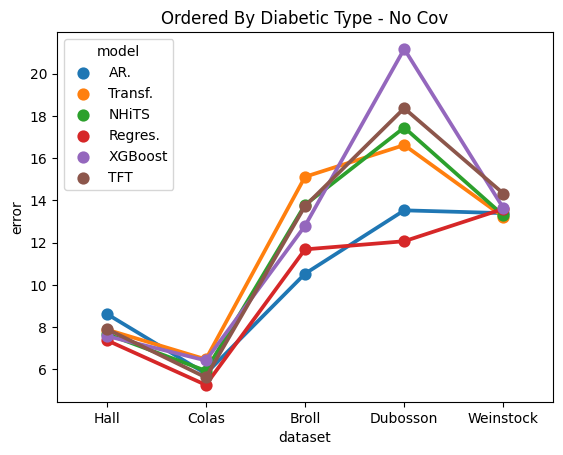

In [5]:
# Combine Cov/No Cov Error bars
error_bars_cov = rename_data(error_bars_cov)
error_bars_nocov = rename_data(error_bars_nocov)

def prepare_data(df):
    df = df.stack().reset_index()
    df["type"] = df["level_1"].apply(lambda x: "ID" if "ID" in x else "OOD")
    df = df[df["type"] == "ID"]
    df.columns = ["model", "dataset", "error", "type"]
    df["dataset"] = df["dataset"].apply(lambda x: x.split(" ")[0])

    return df

df_nocov = rename_data(prepare_data(df_nocov_rmse))
df_nocov = pd.merge(df_nocov, error_bars_cov[["model", "dataset", "type","error_value"]], on=["model","dataset","type"], how="left").fillna(0)
order = ["Hall","Colas","Broll","Dubosson","Weinstock"]
df_nocov = df_nocov.sort_values(by="dataset", key= lambda x: x.map({val: key for key, val in list(enumerate(order))}))

def error(x, df):
    err = df.loc[df["error"] == x]["error_value"].to_numpy()
    print(err)

    return x - err, x + err

plt.figure()
fig1 = sns.pointplot(
    df_nocov, 
    x=df_nocov["dataset"], 
    y="error", 
    hue=df_nocov["model"], 
    order=["Hall","Colas","Broll","Dubosson","Weinstock"],
    errorbar = lambda x: error(x, df_nocov)
)
fig1.set_title("Ordered By Diabetic Type - No Cov")


error(df_nocov["error"].to_numpy(), df_nocov)

# plt.errorbar(df_nocov["dataset"], df_nocov["error"], xerr=None, yerr=df_nocov["error_value"], barsabove=True)
# df_no
# df_nocov["error_value"]
# df_nocov["error"][2]
# df_nocov.loc[df_nocov["error"] == 8.632595]

# plt.figure()
# sns.pointplot(df1, x=df1["dataset"], y="error", hue=df1["model"], order=["hall","colas","iglu","dubosson","weinstock"]).set_title("Ordered By Diabetic Type - No Cov")



      model    dataset      error type
0       AR.      Colas   5.796469   ID
2       AR.   Dubosson  13.531802   ID
4       AR.       Hall   8.632595   ID
6       AR.      Broll  10.530744   ID
8       AR.  Weinstock  13.399260   ID
10    NHiTS      Colas   5.933243   ID
12    NHiTS   Dubosson  17.452712   ID
14    NHiTS       Hall   7.682546   ID
16    NHiTS      Broll  13.791463   ID
18    NHiTS  Weinstock  13.289205   ID
20      TFT      Colas   5.619780   ID
22      TFT   Dubosson  18.365973   ID
24      TFT       Hall   7.916066   ID
26      TFT      Broll  13.734609   ID
28      TFT  Weinstock  14.324450   ID
30  Regres.      Colas   5.263553   ID
32  Regres.   Dubosson  12.068422   ID
34  Regres.       Hall   7.383182   ID
36  Regres.      Broll  11.682952   ID
38  Regres.  Weinstock  13.602916   ID
40  XGBoost      Colas   6.421443   ID
42  XGBoost   Dubosson  21.176230   ID
44  XGBoost       Hall   7.579501   ID
46  XGBoost      Broll  12.799580   ID
48  XGBoost  Weinstock  1

Text(0.5, 1.0, 'Ordered By Diabetic Type - No Cov')

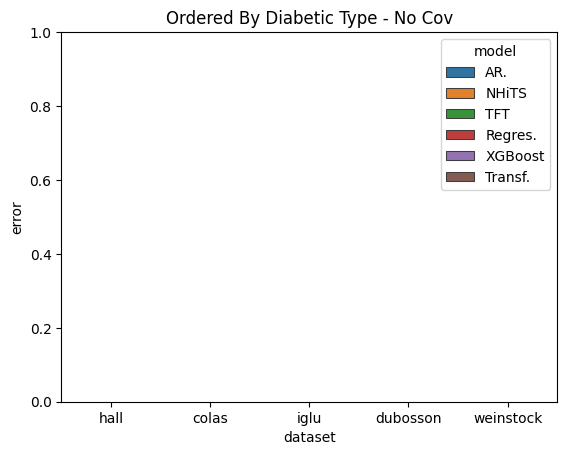

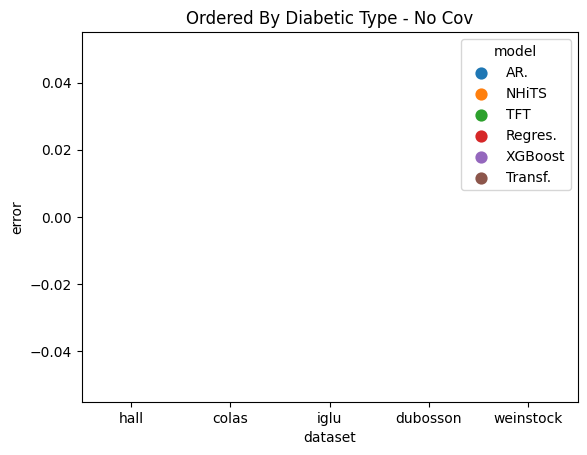

In [74]:
# 3. LOTS OF PLOTS


df1 = rename_data(prepare_data(df_nocov_rmse))

print(df1)

# 3a.Ordered by difficulty

#  ID vs. OOD
# plt.figure()
# sns.boxenplot(df1, x="model", y="error", hue="type")